<a href="https://colab.research.google.com/github/eneskosar/Human-Activity-Recognition/blob/master/CNNLSTM_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

# Imports

In [ ]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML
import h5py
import time

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from keras.layers import Conv1D,Conv2D, MaxPooling2D, BatchNormalization,MaxPooling1D,Activation
from keras.utils import np_utils
from keras.layers.wrappers import TimeDistributed


In [ ]:
results = np.zeros([8])

start_time = time.time()
dir = "/content/gdrive/My Drive/Colab Notebooks/HARprojectV2/"

hf = h5py.File(dir+'HAR_Dataset.h5', 'r')

sensors = ["chest", "rArm", "lArm", "lLeg", "rLeg", "chest_lArm_lLeg", "all"]
sensor = "all"
for i in range(8):
  DataTraining = hf.get(f'{sensor}DataTrainingSubject{i+1}')[()]
  LabelsTraining = hf.get(f'{sensor}LabelsTrainingSubject{i+1}')[()]

  DataValidation = hf.get(f'{sensor}DataValidationSubject{i+1}')[()]
  LabelsValidation = hf.get(f'{sensor}LabelsValidationSubject{i+1}')[()]

  # Network hyper-parameters
  n_timesteps = DataTraining.shape[1] # 5 sec x 25 Hz = 125 rows
  n_features = DataTraining.shape[2] # 5 units x 9 sensors = 45 columns
  n_activities = LabelsTraining.shape[1] # 19 activities

  DataTraining = DataTraining.reshape((len(DataTraining),5, 25, n_features))
  DataValidation = DataValidation.reshape((len(DataValidation),5, 25, n_features))

  epochs = 50
  batch_size = 64

  # Create network

  model_3 = Sequential()
  model_3.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'), input_shape=(None, 25, n_features)))
  model_3.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu')))
  model_3.add(TimeDistributed(Dropout(0.2)))
  model_3.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model_3.add(TimeDistributed(Flatten()))
  model_3.add(LSTM(32))
  model_3.add(Dropout(0.5))
  model_3.add(Dense(64))
  model_3.add(BatchNormalization())
  model_3.add(Activation('relu'))
  model_3.add(Dense(n_activities, activation='softmax'))
  model_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  print(model_3.summary())

  # Fit network
  training_start_time = time.time()

  model_3_fit = model_3.fit(DataTraining, LabelsTraining,
                            epochs = epochs,
                            batch_size = batch_size,
                            verbose = 2,
                            validation_data = (DataValidation, LabelsValidation))
  training_end_time = time.time()

  # Evaluate network on test set

  score_3 = model_3.evaluate(DataValidation, LabelsValidation, verbose = 2)
  results[i] = score_3[1]*100
  print("Loss on test set: " + "{:.3f}".format(score_3[0]))
  print("Accuracy on test set: " + "{:.2f}".format(score_3[1] * 100) + "%")

  # Plot Loss vs. Epoch

    #fig, p = plt.subplots()
    #p.plot(range(epochs), model_3_fit.history["loss"], label = "Training loss")
    #p.plot(range(epochs), model_3_fit.history["val_loss"], label = "Validation loss")
    #p.set_xlabel("Epoch")
    #p.set_ylabel("Loss")
    #p.set_title("Loss vs. Epoch")
    #p.legend()

  # Plot Accuracy vs. Epoch

    #fig, p = plt.subplots()
    #p.plot(range(epochs), model_3_fit.history["accuracy"], label = "Training accuracy")
    #p.plot(range(epochs), model_3_fit.history["val_accuracy"], label = "Validation accuracy")
    #p.set_xlabel("Epoch")
    #p.set_ylabel("Accuracy")
    #p.set_title("Accuracy vs. Epoch")
    #p.legend()

end_time = time.time()

print(end_time-start_time)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_41 (TimeDis (None, None, 21, 64)      14464     
_________________________________________________________________
time_distributed_42 (TimeDis (None, None, 17, 64)      20544     
_________________________________________________________________
time_distributed_43 (TimeDis (None, None, 17, 64)      0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, None, 8, 64)       0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, None, 512)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                69760     
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)               

In [ ]:
print(results)

[84.47368145 83.4210515  81.84210658 80.35087585 91.92982316 85.52631736
 88.59649301 78.1578958 ]


In [ ]:
avg = results.mean(axis=0)
print(avg)


84.28728058934212


In [ ]:
def show_confusion_matrix(validations, predictions): 
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1,
                xticklabels = range(19), yticklabels = range(19), annot = True, fmt = 'd')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

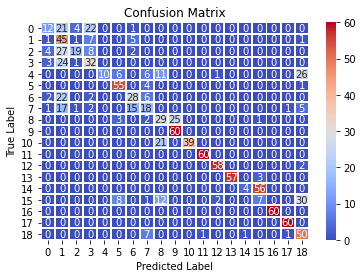

              precision    recall  f1-score   support

           0       0.52      0.20      0.29        60
           1       0.29      0.75      0.42        60
           2       0.73      0.32      0.44        60
           3       0.44      0.53      0.48        60
           4       1.00      0.17      0.29        60
           5       0.76      0.92      0.83        60
           6       0.55      0.47      0.50        60
           7       0.41      0.30      0.35        60
           8       0.40      0.48      0.44        60
           9       0.71      1.00      0.83        60
          10       1.00      0.65      0.79        60
          11       0.98      1.00      0.99        60
          12       0.95      0.97      0.96        60
          13       1.00      0.95      0.97        60
          14       0.80      0.07      0.12        60
          15       0.10      0.12      0.11        60
          16       1.00      1.00      1.00        60
          17       0.97    

In [ ]:
y_pred_test = model_3.predict(DataValidation)

# Accept the activity with the highest probability amongst predictions

max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(LabelsValidation, axis = 1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))